In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

import mitequinox.utils as ut
import mitequinox.plot as pl
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5797422.datarmor0/parcels-502090/libparcels_random_71d98019-6321-47e1-8c59-22f583373e2a.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3
                 )
#
client = Client(cluster)

In [3]:
client

<Client: 'tcp://10.148.0.60:58851' processes=0 threads=0, memory=0 B>

In [4]:
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean","variance","mean_square"]
grid = ut.load_grd()
ds = xr.merge([xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/'+diag+'.zarr'
                           ).drop(['Eta','KPPhbl','SSS','SST','oceTAUX','oceTAUY']).rename({'SSU':diag+'_SSU','SSV':diag+'_SSV'}) for diag in D])
#for diag in D:
#    ds = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/'+diag+'.zarr')
#    ds = ds.drop(['Eta','KPPhbl','SSS','SST','oceTAUX','oceTAUY']).rename({'SSU':diag+'_SSU','SSV':diag+'_SSV'})
#    ds = xr.merge([ds,grid])
#ds_var = ds_var.drop(['Eta','KPPhbl','SSS','SST','oceTAUX','oceTAUY']).rename({'SSU':'var_SSU','SSV':'var_SSV'})
#xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
     #          for v in V for d in D])
#xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds = xr.merge([ds,grid])
sub = 1
ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub),i_g=slice(0,None,sub),j_g=slice(0,None,sub))
#ds = ds.where(ds.Depth>500, drop=False)

ds = ds.persist()
print(ds)

<xarray.Dataset>
Dimensions:          (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates: (12/32)
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                (i) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * i_g              (i_g) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * j                (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * j_g              (j_g) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    CS               (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    ...               ...
  * k_p1             (k_p1) int64 0 1 2 3 4 5 6 7 8 ... 83 84 85 86 87 88 89 90
  * k_u              (k_u) int64 0 1 2 3 4 5 6 7 8 ... 82 83 84 85 86 87 88 89
    rA               (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs              (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.nda

In [5]:
ds = ds.drop(['i_g','j_g'])

ds = ds.rename({'i_g':'i','j_g':'j'})
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC
ds = ds.persist()

In [6]:
ds['zonal_velocity_mean'] =  ds['mean'+'_SSU']*ds.CS - ds["mean"+'_SSV']*ds.SN
ds['meridional_velocity_mean'] =  ds['mean'+'_SSU']*ds.SN + ds["mean"+'_SSV']*ds.CS
ds['zonal_velocity_variance'] =  ds['variance_SSU']*ds.CS**2+ds['variance_SSV']*ds.SN**2
ds['meridional_velocity_variance'] =  ds['variance_SSU']*ds.SN**2+ds['variance_SSV']*ds.CS**2

In [7]:
ds_rot = llcreader.faces_dataset_to_latlon(ds.drop(['mean_SSU','mean_SSV','variance_SSU','variance_SSU']))
ds_rot = ds_rot.persist()
print(ds_rot)

<xarray.Dataset>
Dimensions:                       (face: 13, i: 17280, j: 12960, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates: (12/30)
  * face                          (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                             (i) int64 0 1 2 3 ... 17276 17277 17278 17279
  * j                             (j) int64 0 1 2 3 ... 12956 12957 12958 12959
  * k                             (k) int64 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k_l                           (k_l) int64 0 1 2 3 4 5 ... 84 85 86 87 88 89
  * k_p1                          (k_p1) int64 0 1 2 3 4 5 ... 85 86 87 88 89 90
    ...                            ...
    rAw                           (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz                           (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxC                           (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC                           (j, i) fl

In [8]:
ds_rot = ds_rot.drop([C for C in ds_rot.coords][3:])
ds_rot = ds_rot.drop(['face'])


df_rot = ds_rot.to_dataframe()    

In [15]:
ds_sub = ds_rot.where((ds_rot.lon<=-125)&(ds_rot.lon>=-126),drop=True)
ds_sub = ds_sub.where((ds_sub.lat>=35)&(ds_sub.lat<=36),drop=True)

In [17]:
dfE_sub = ds_sub.to_dataframe()

In [16]:
ds_sub = ds_sub.compute()

Text(0.5, 0, 'Longitude')

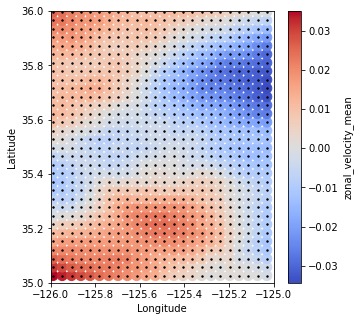

In [57]:
fig,ax = plt.subplots(1,1, figsize=(5,5))
dfE_sub.plot.scatter(x='lon',y='lat',c ='zonal_velocity_mean',s=100,cmap='coolwarm',ax=ax)
dfE_sub.plot.scatter(x='lon',y='lat',s=2,ax=ax,c='k')
ax.set_ylim(35,36);ax.set_xlim(-126,-125);ax.set_ylabel('Latitude');ax.set_xlabel('Longitude')
#plt.contourf(ds_sub.lon.values,ds_sub.lat.values,ds_sub.lon.values)

In [18]:
# output archives
import os
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_california")
llc_zarr = os.path.join(out_dir, "llc.zarr")

parcels_index= 'time_mean'
parcels_name = "llc_parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)

In [19]:
df = dd.read_parquet(parcels_path)

In [20]:
df = df.drop(columns=['SST_interp','SSS_interp','Eta_interp','salinity','temperature','sea_level']).rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'})
df = pa.degs2ms(df) #Convert in m/s 


df= df.compute()

In [21]:
df_sub = df[(df.lon<=-125)&(df.lon>=-126)
            &(df.lat>=35)&(df.lat<=36)]

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


Text(0.5, 0, 'Longitude')

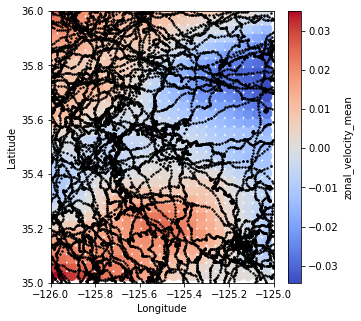

In [22]:
df_subfig,ax = plt.subplots(1,1, figsize=(5,5))
dfE_sub.plot.scatter(x='lon',y='lat',c ='zonal_velocity_mean',s=100,cmap='coolwarm',ax=ax)
df_sub.plot.scatter(x='lon',y='lat',s=2,ax=ax,c='k')
ax.set_ylim(35,36);ax.set_xlim(-126,-125);ax.set_ylabel('Latitude');ax.set_xlabel('Longitude')

Text(0.5, 0, 'Longitude')

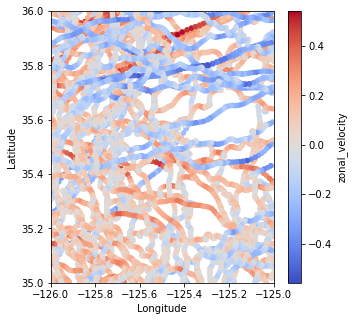

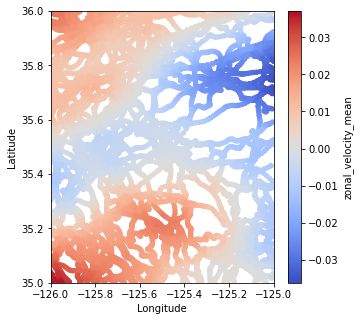

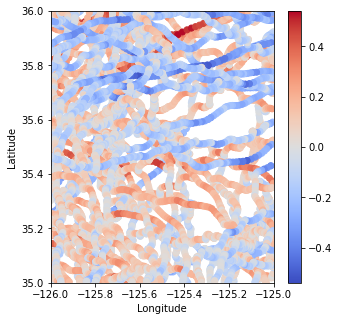

In [35]:
df_subfig,ax = plt.subplots(1,1, figsize=(5,5))
df_sub.plot.scatter(x='lon',y='lat',c='zonal_velocity',cmap='coolwarm',ax=ax)
ax.set_ylim(35,36);ax.set_xlim(-126,-125);ax.set_ylabel('Latitude');ax.set_xlabel('Longitude')
fig,ax = plt.subplots(1,1, figsize=(5,5))
df_sub.plot.scatter(x='lon',y='lat',c='zonal_velocity_mean',cmap='coolwarm',ax=ax)
ax.set_ylim(35,36);ax.set_xlim(-126,-125);ax.set_ylabel('Latitude');ax.set_xlabel('Longitude')
fig,ax = plt.subplots(1,1, figsize=(5,5))
cs = plt.scatter(df_sub.lon,df_sub.lat,c=(df_sub.zonal_velocity-df_sub.zonal_velocity_mean),cmap='coolwarm')
plt.colorbar(cs,ax=ax)
#df_sub.plot.scatter(x='lon',y='lat',c='zonal_velocity_mean',cmap='coolwarm',ax=ax) 
ax.set_ylim(35,36);ax.set_xlim(-126,-125);ax.set_ylabel('Latitude');ax.set_xlabel('Longitude')

In [105]:
df_sub['binned_zonal_velocity']=np.full_like(df_sub.zonal_velocity_mean,df_sub.zonal_velocity_mean.agg('mean'))

TypeError: Invalid shape (12701,) for image data

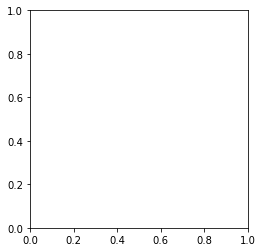

In [112]:
df_sub.plot.scatter(binned_zonal_velocity)

In [38]:
t_start = df_sub.index.min()
t_end = df_sub.index.max()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start, t_end, delta_t)

2011-11-15 00:00:00 2012-11-09 01:00:00 360.0416666666667


In [39]:

# temporal bins
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)

In [84]:
df_sub = df_sub.sort_index()

In [87]:
df1 = df_sub.loc[t_bins[0]:t_bins[1]]
df2 = df_sub.loc[t_bins[1]:t_bins[2]]

Text(0.5, 0, 'Longitude')

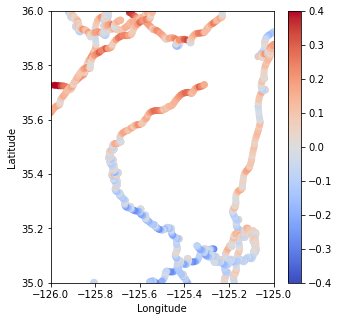

In [119]:
fig,ax = plt.subplots(1,1, figsize=(5,5))
#dfE_sub.plot.scatter(x='lon',y='lat',c ='zonal_velocity_mean',s=100,cmap='coolwarm',ax=ax,colorbar=False)


cs = plt.scatter(df1.lon,df1.lat,c=(df1.zonal_velocity-df1.zonal_velocity_mean),cmap='coolwarm',vmax=0.4,vmin=-0.4)
plt.colorbar(cs,ax=ax)


#df_sub.plot.scatter(x='lon',y='lat',c='zonal_velocity_mean',cmap='coolwarm',ax=ax) 
ax.set_ylim(35,36);ax.set_xlim(-126,-125);ax.set_ylabel('Latitude');ax.set_xlabel('Longitude')

Text(0.5, 0, 'Longitude')

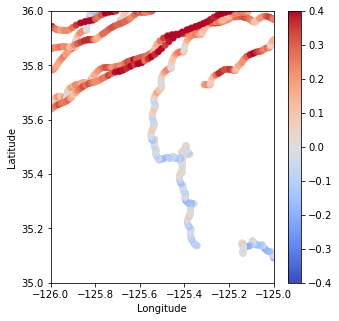

In [118]:
fig,ax = plt.subplots(1,1, figsize=(5,5))
#dfE_sub.plot.scatter(x='lon',y='lat',c ='zonal_velocity_mean',s=100,cmap='coolwarm',ax=ax,colorbar=False)


cs = plt.scatter(df2.lon,df2.lat,c=(df2.zonal_velocity-df2.zonal_velocity_mean),cmap='coolwarm',vmax=0.4,vmin=-0.4)
plt.colorbar(cs,ax=ax)


#df_sub.plot.scatter(x='lon',y='lat',c='zonal_velocity_mean',cmap='coolwarm',ax=ax) 
ax.set_ylim(35,36);ax.set_xlim(-126,-125);ax.set_ylabel('Latitude');ax.set_xlabel('Longitude')

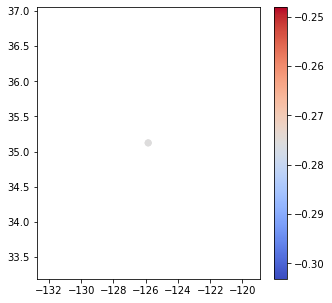

In [64]:
fig,ax = plt.subplots(1,1, figsize=(5,5))
cs = plt.scatter(df_sub.loc[t_bins[6]].lon,df_sub.loc[t_bins[0]].lat,c=(df_sub.loc[t_bins[0]].zonal_velocity),cmap='coolwarm')
plt.colorbar(cs,ax=ax)

In [43]:
df_sub['time_cut'] = pd.cut(df_sub.zonal_velocity, bins=t_bins)

ValueError: Input array must be 1 dimensional

In [4]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'

run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_prime'])
df = p.df['time_prime']

df = pa.degs2ms(df) #Convert in m/s 



In [5]:
#Subdataframe : we keep only velocity field
#df_uv = df.drop(columns = ['sea_level','temperature','salinity','SST_interp','SSS_interp','Eta_interp']) #drop unused variables

df_uv = df.rename(columns={'SSU_interp':'mean_zonal_velocity','SSV_interp':'mean_meridional_velocity'})#.persist()

In [6]:
t_start = df_uv.index.min().compute()
t_end = df_uv.index.max().compute()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start, t_end, delta_t)

2011-11-15 00:00:00 2012-11-09 01:00:00 360.0416666666667


In [7]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-70.,70., dl)

# temporal bins
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)

In [8]:
df_uv['lon'] = (df_uv['lon']+180)%360 - 180
df_uv['lon_cut'] = df_uv['lon'].map_partitions(pd.cut, lon_bins)
df_uv['lat_cut'] = df_uv['lat'].map_partitions(pd.cut, lat_bins)
df_uv['time_cut'] = df_uv.map_partitions(cut, t_bins)
df_uv = df_uv.persist()

In [9]:
df_reset = df_uv.reset_index().persist()
df_start = df_reset[df_reset.time==t_start]
df_end = df_reset[df_reset.time==t_end]

In [21]:
df_bin_end = df_end[(df_end.lon<=-99)&(df_end.lon>=-101)&(df_end.lat<=2)&(df_end.lat>=-2)].compute()
df_bin_start = df_start[(df_start.lon<=-99)&(df_start.lon>=-101)&(df_start.lat<=2)&(df_start.lat>=-2)].compute()

In [29]:
df_sub = df_uv[(df_uv.lon<=-99)&(df_uv.lon>=-101)&(df_uv.lat<=2)&(df_uv.lat>=-2)].compute()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='lon', ylabel='lat'>

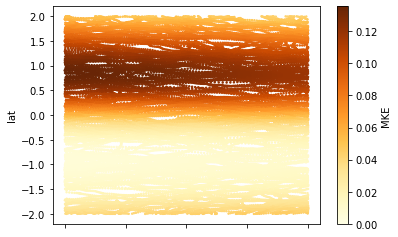

In [39]:
#df_sub['MKE'] = df_sub.mean_zonal_velocity**2+df_sub.mean_meridional_velocity**2
df_sub.plot.scatter(x='lon',y='lat',s=2,c='MKE',cmap='YlOrBr',vmin=0)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='lon', ylabel='lat'>

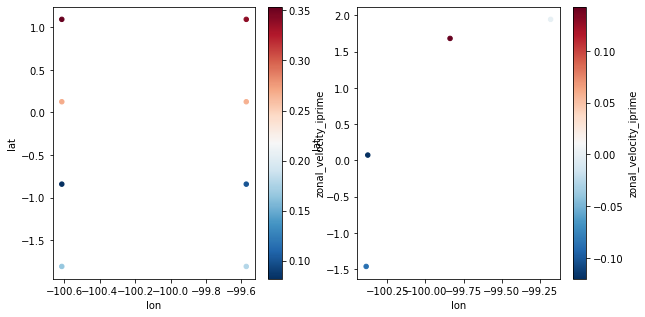

In [47]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
df_bin_start.plot.scatter(ax=ax[0],x='lon',y='lat',c='zonal_velocity_iprime',cmap='RdBu_r')
df_bin_end.plot.scatter(ax=ax[1],x='lon',y='lat',c='zonal_velocity_iprime',cmap='RdBu_r')

In [12]:
count = (df_uv
         .groupby([df_uv.lon_cut, df_uv.lat_cut, df_uv.time_cut])
         .count()['z']
         .compute()
         .rename('count')
         .to_frame()
        )
#count = count/30 # normalize per number of days

count['time'] = count.index.to_series().apply(lambda v: v[2].left)

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3821, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('dataframe-groupby-count-chunk-bc6844bdf319a132af82a9f8dfb4751f', 0, 1006, 0)"


KeyboardInterrupt: 

In [12]:
count = pa.add_geodata(count)

ds = (count
      .set_index(['lon', 'lat', 'time'])
      .to_xarray()
     )

In [ ]:
ds = ds.where(ds['count']>0,drop=False)

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3821, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('dataframe-groupby-count-chunk-bc6844bdf319a132af82a9f8dfb4751f', 0, 48, 0)"
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  F

In [ ]:
count_bin = (df_uv
         .groupby([df_uv.lon_cut, df_uv.lat_cut])
         .count()
         .compute()
         ['z'].rename('count')
         .to_frame()
        )

In [ ]:
count_bin = pa.add_geodata(count_bin)
#count_bin['density'] = count_bin['count']/count_bin['area']

ds_bin = (count_bin
      .set_index(['lon', 'lat'])
      .to_xarray()
     )

In [25]:
def plot_maps(ds,vlim,sub_axes,fig,colmap='RdBu_r',figsize = (10,5)):
    crs = ccrs.Robinson()
    ax = fig.add_subplot(sub_axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat',ax=ax,transform=ccrs.PlateCarree(),cmap=colmap,label=False)
    ax.gridlines(draw_labels=True)
    return fig,ax

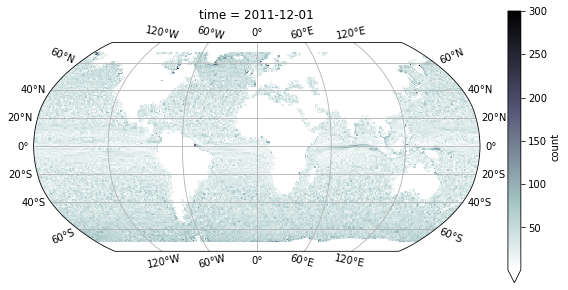

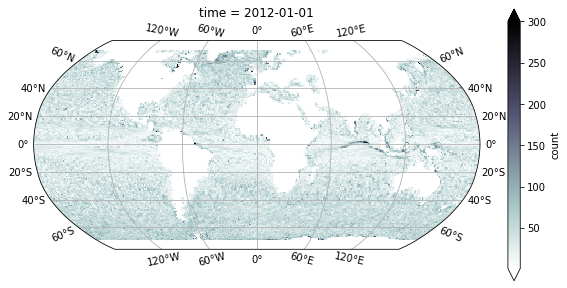

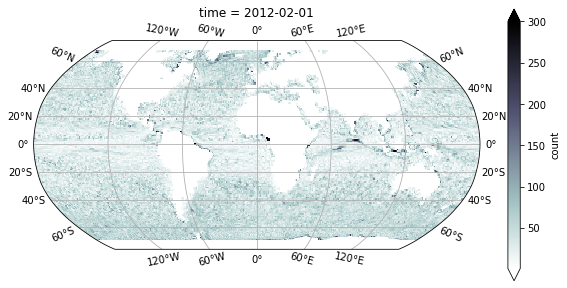

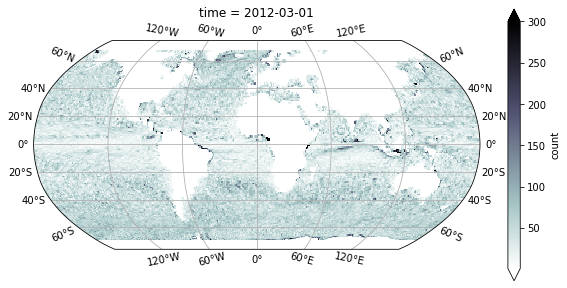

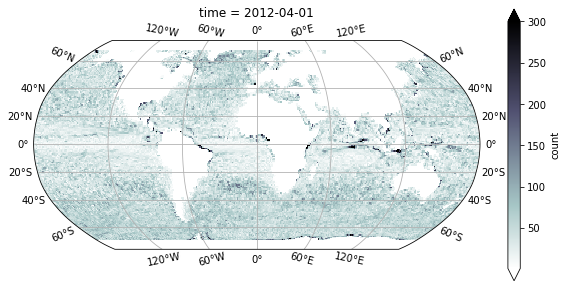

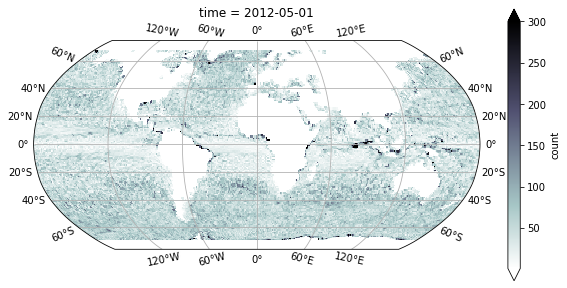

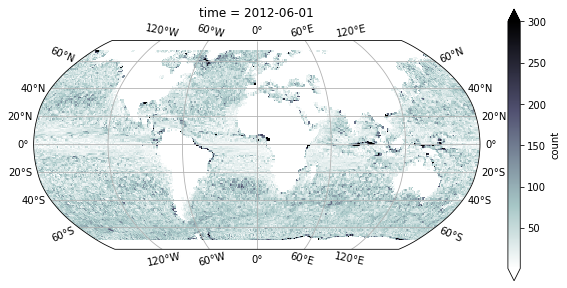

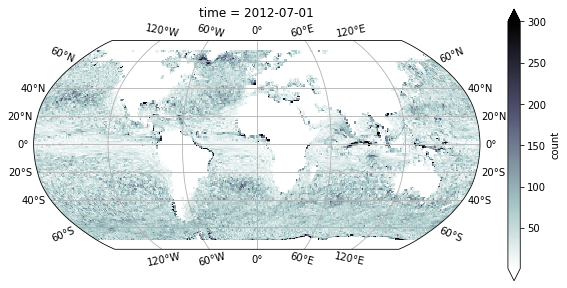

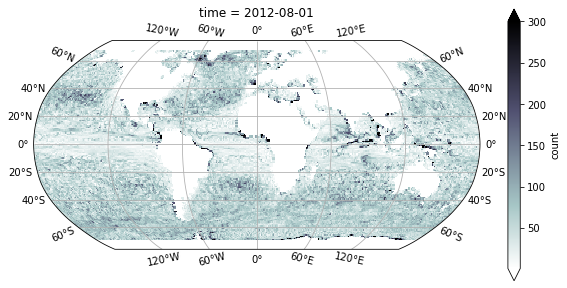

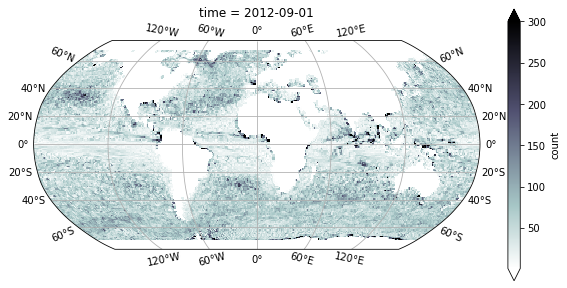

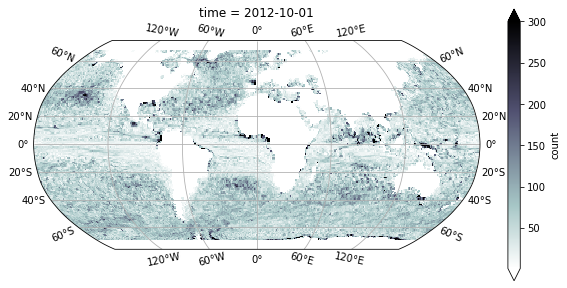

In [35]:
for i in range(ds['count'].shape[2]):
    fig = plt.figure(figsize=figsize)
    plot_maps(ds['count'].isel(time=i),[1,300],121,fig,colmap='bone_r')
    plot_maps((ds['count'].isel(time=i)/ds_bin['count']),[0,0.01],122,fig,colmap='bone_r')

In [37]:
count_bin = (df_uv
         .groupby([df_uv.lon_cut, df_uv.lat_cut])
         .count()
         .compute()
         ['z'].rename('count')
         .to_frame()
        )

# normalize by time window length
#count_bin = count_bin/delta_t
#

In [38]:
count_bin = pa.add_geodata(count_bin)
#count_bin['density'] = count_bin['count']/count_bin['area']

ds_bin = (count_bin
      .set_index(['lon', 'lat'])
      .to_xarray()
     )

In [39]:
ds_bin

<xarray.Dataset>
Dimensions:  (lat: 139, lon: 359)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5
  * lat      (lat) float64 -69.5 -68.5 -67.5 -66.5 -65.5 ... 65.5 66.5 67.5 68.5
Data variables:
    count    (lon, lat) float64 2.043e+04 2.084e+04 1.994e+04 ... 0.0 0.0 0.0

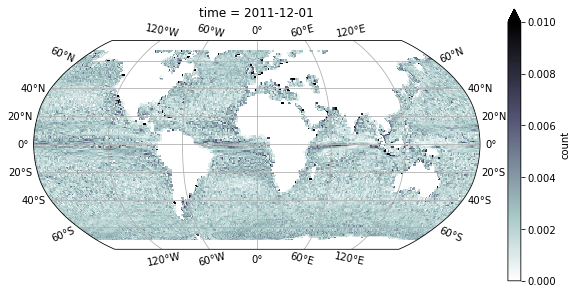

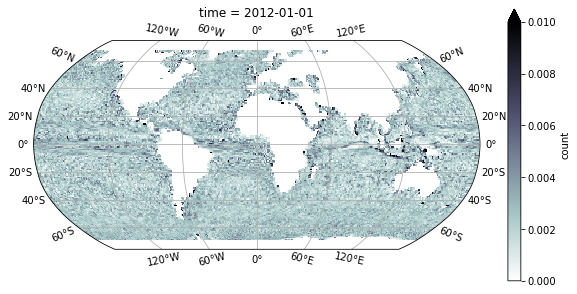

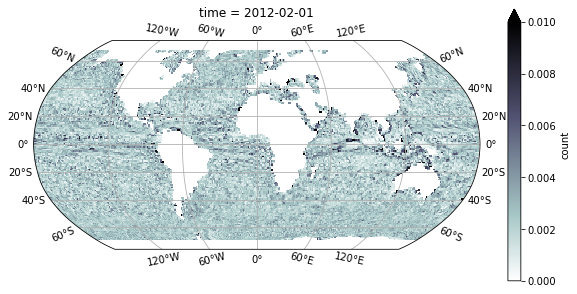

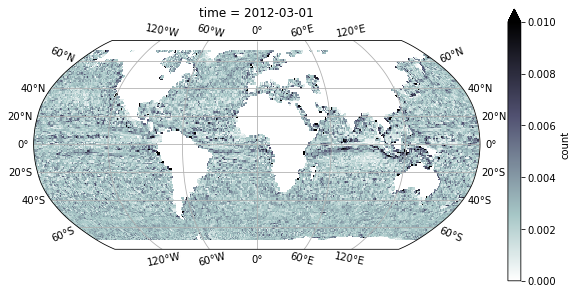

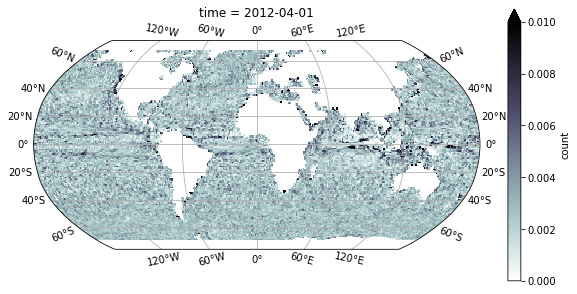

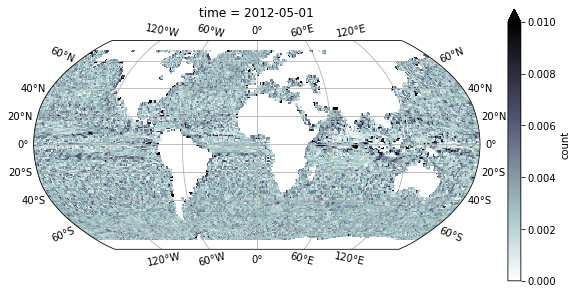

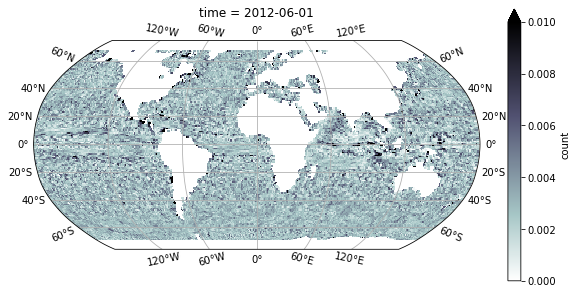

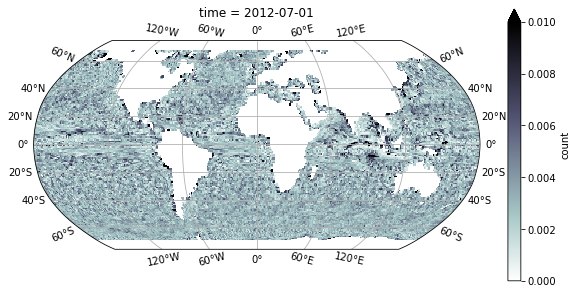

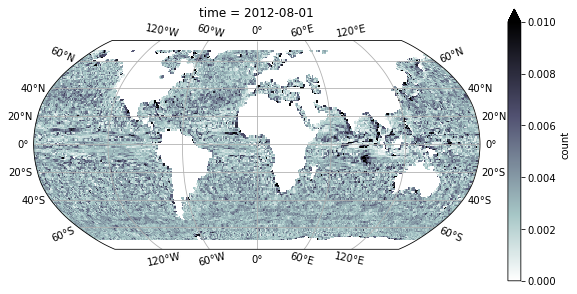

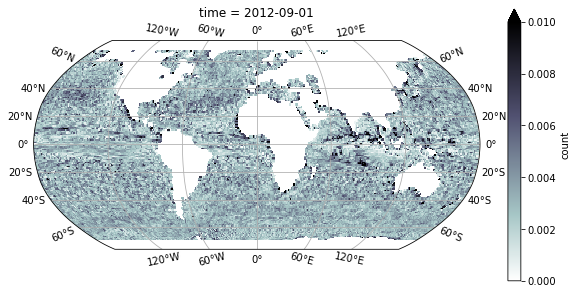

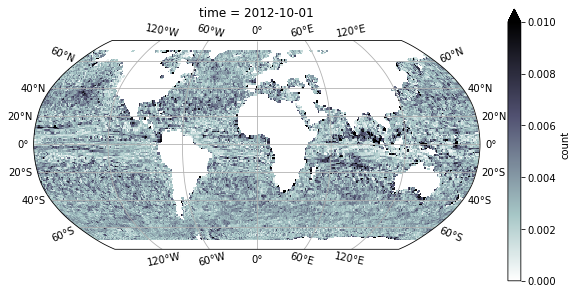

In [46]:
for i in range(ds['count'].shape[2]):
    plot_maps((ds['count'].isel(time=i)/ds_bin['count']),[0,0.01],colmap='bone_r')

In [9]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
